## Import torch and check whether GPU is available

In [1]:
import torch

In [2]:
print(torch.cuda.is_available())

True


## Extract Bounding Box Information

Bounding box information stored in 'digitStruct.mat'; convert to readable/usable format --> dict

In [7]:
import h5py
import os
import pickle

def get_name(index, hdf5_data):
    
    name_ref = hdf5_data['digitStruct']['name'][index].item()
    name = ''.join([chr(v[0]) for v in hdf5_data[name_ref]])
    
    return name


# bbox information stored in format height, left, top, width, label; left, top are coordinates of top-left point
def get_box_data(index, hdf5_data):
    
    bbox = {}
    bbox_item = hdf5_data['digitStruct']['bbox'][index].item()
    for key in ['height', 'left', 'top', 'width', 'label']:
        attr = hdf5_data[bbox_item][key]
        if hasattr(attr, 'shape') and attr.shape[0] > 1:
            bbox[key] = [hdf5_data[attr.value[j].item()][()][0][0] for j in range(len(attr))]
        else:
            bbox[key] = [attr[()][0][0]]
            
    return bbox


def get_digit_structure(hdf5_data):
    
    return [{'name': get_name(i, hdf5_data), 'bbox': get_box_data(i, hdf5_data)} 
            for i in range(len(hdf5_data['digitStruct']['name']))]

# save to useable format so no conversion needed every time
def extract_and_save_structures(extracted_dir, mat_file_name='digitStruct.mat', pickle_file_name='digitStruct.pkl'):
    mat_file_path = os.path.join(extracted_dir, mat_file_name)
    pickle_file_path = os.path.join(extracted_dir, pickle_file_name)
    
    # if extracted or .pkl exists already, load directly; if not, extract from .mat
    if os.path.exists(pickle_file_path):
        print('Loading data from existing file')
        with open(pickle_file_path, 'rb') as file:
            digit_struct = pickle.load(file)
    else:
        print('Extracting data from .mat')
        with h5py.File(mat_file_path, 'r') as f:
            digit_struct = get_digit_structure(f)
            with open(pickle_file_path, 'wb') as file:
                pickle.dump(digit_struct, file)
    
    return digit_struct


In [8]:

# 'digitStruct.mat' in 'train' folder; also has 'digitStruct.mat' in 'test' folder
extracted_dir = 'train'
digit_struct = extract_and_save_structures(extracted_dir)
for i in range(5):  
    print(digit_struct[i])
    

Loading data from existing file
{'name': '1.png', 'bbox': {'height': [219.0, 219.0], 'left': [246.0, 323.0], 'top': [77.0, 81.0], 'width': [81.0, 96.0], 'label': [1.0, 9.0]}}
{'name': '2.png', 'bbox': {'height': [32.0, 32.0], 'left': [77.0, 98.0], 'top': [29.0, 25.0], 'width': [23.0, 26.0], 'label': [2.0, 3.0]}}
{'name': '3.png', 'bbox': {'height': [15.0, 15.0], 'left': [17.0, 25.0], 'top': [5.0, 5.0], 'width': [8.0, 9.0], 'label': [2.0, 5.0]}}
{'name': '4.png', 'bbox': {'height': [34.0, 34.0], 'left': [57.0, 72.0], 'top': [13.0, 13.0], 'width': [15.0, 13.0], 'label': [9.0, 3.0]}}
{'name': '5.png', 'bbox': {'height': [46.0, 46.0], 'left': [52.0, 74.0], 'top': [7.0, 10.0], 'width': [21.0, 15.0], 'label': [3.0, 1.0]}}


## Define SVHN Dataset

For each instance of this dataset we need the actual image with resizing, its bounding box information after resizing, and the corresponding labels.

In [9]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class SVHNDataset(Dataset):
    
    def __init__(self, digit_struct, root_dir, transform=None):
        self.digit_struct = digit_struct
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.digit_struct)

    # open image, convert to RGB
    def __getitem__(self, idx):
        item = self.digit_struct[idx]
        img_path = os.path.join(self.root_dir, item['name'])
        img = Image.open(img_path).convert('RGB')
        
        # use x_min, y_min, x_max, y_max instead of left, top, width, height 
        num_boxes = len(item['bbox']['height'])
        boxes = []
        for i in range(num_boxes):
            x_min = item['bbox']['left'][i]
            y_min = item['bbox']['top'][i]
            x_max = x_min + item['bbox']['width'][i]
            y_max = y_min + item['bbox']['height'][i]
            boxes.append([x_min, y_min, x_max, y_max])
        
        # convert bounding box information to tensors (float to be more accurate)
        boxes = torch.tensor(boxes, dtype=torch.float32)
        
        # labels are integers
        labels = torch.tensor(item['bbox']['label'], dtype=torch.int64)
        
        # for a single image there could be multiple boxes and corresponding labels
        target = {'boxes': boxes, 'labels': labels}
        
        # transform if needed
        if self.transform:
            img, target = self.transform(img, target)
        
        return img, target, item['name']



In [10]:
from torchvision.transforms import functional as F

# resize bounding boxes accordingly
def resize_boxes(boxes, original_size, new_size):
    
    # compute resizing ratios
    ratios = [new_size[0] / original_size[0], new_size[1] / original_size[1]]
   
    resized_boxes = []
    for box in boxes:
        resized_box = [torch.round(box[0] * ratios[0]).int(), 
                       torch.round(box[1] * ratios[1]).int(), 
                       torch.round(box[2] * ratios[0]).int(), 
                       torch.round(box[3] * ratios[1]).int()]
        resized_boxes.append(resized_box)
        
    return torch.tensor(resized_boxes, dtype=torch.int64)

# transform images 224x224 and change bounding boxes accordingly
def my_transform(img, target):
    
    original_size = img.size
    new_size = (224, 224)
    
    img = F.resize(img, new_size)
    img = F.to_tensor(img)
    
    if 'boxes' in target:
        target['boxes'] = resize_boxes(target['boxes'], original_size, new_size)
        
    return img, target


In [11]:
from torch.utils.data._utils.collate import default_collate

# use custom 'collate' since each image can have annotations of different length (bbox and label)
def collate_fn(batch):
    
    batch_images = [item[0] for item in batch] # image
    batch_targets = [item[1] for item in batch] # bbox and label
    batch_names = [item[2] for item in batch] # keep track of image names for later visualization
    
    batch_images = default_collate(batch_images)
    
    return batch_images, batch_targets, batch_names


## Load dataset, split into train and validation sets, load data

In [12]:
from torch.utils.data.dataset import random_split

dataset = SVHNDataset(digit_struct=digit_struct, root_dir='train', transform=my_transform)

val_size = int(0.2 * len(dataset))  
train_size = len(dataset) - val_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn)


In [13]:
print(f'Length of train dataloader is {len(train_loader)}')
print(f'Length of validation dataloader is {len(val_loader)}')

Length of train dataloader is 1671
Length of validation dataloader is 418


## Check content in a single batch

In [37]:
# contains image tensor, bbox and label tensor, image name tensor
for batch in train_loader:
    print(batch)
    break

(tensor([[[[0.1647, 0.1725, 0.1804,  ..., 0.1451, 0.1373, 0.1333],
          [0.1647, 0.1725, 0.1804,  ..., 0.1451, 0.1373, 0.1333],
          [0.1647, 0.1725, 0.1804,  ..., 0.1451, 0.1412, 0.1373],
          ...,
          [0.2157, 0.2118, 0.2118,  ..., 0.1176, 0.1255, 0.1255],
          [0.2157, 0.2118, 0.2078,  ..., 0.1176, 0.1255, 0.1255],
          [0.2157, 0.2118, 0.2078,  ..., 0.1176, 0.1255, 0.1255]],

         [[0.1608, 0.1686, 0.1725,  ..., 0.1216, 0.1176, 0.1176],
          [0.1608, 0.1686, 0.1725,  ..., 0.1216, 0.1176, 0.1176],
          [0.1608, 0.1686, 0.1725,  ..., 0.1216, 0.1176, 0.1216],
          ...,
          [0.1765, 0.1765, 0.1804,  ..., 0.1137, 0.1216, 0.1216],
          [0.1765, 0.1804, 0.1804,  ..., 0.1137, 0.1216, 0.1216],
          [0.1765, 0.1804, 0.1804,  ..., 0.1137, 0.1216, 0.1216]],

         [[0.1451, 0.1529, 0.1569,  ..., 0.1294, 0.1216, 0.1137],
          [0.1451, 0.1529, 0.1569,  ..., 0.1294, 0.1216, 0.1137],
          [0.1451, 0.1529, 0.1569,  ..., 

## Training Setup

In [15]:
# please run this so validation will work
!pip install pycocotools

Defaulting to user installation because normal site-packages is not writeable


In [16]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor, FasterRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.rpn import AnchorGenerator

def get_model(num_classes):
    
    # load pre-trained ResNet-50 weights with built-in FPN 
    model = fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
    
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    
    # replace for a new predictor for SVHN dataset with 10+1 classes
    # from now on Fast R-CNN is used (same structure after FPN/RPN or starting from ROI pooling)
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    
    # choose aspect ratios accordingly since the digits are generally taller
    anchor_generator = AnchorGenerator(
        sizes=((32,), (64,), (128,), (256,), (512,)),  
        aspect_ratios=((0.25, 0.5, 0.75),) * 5  
    )
    
    # set anchor generator with custom anchors
    model.rpn.anchor_generator = anchor_generator
    
    return model

num_classes = 11 # '0' for background; '1-9' for 1-9, '10' for 0
model = get_model(num_classes)


In [22]:
import torch
import torch.optim as optim
import os
import json

def train_model(model, config, train_loader, val_loader, start_epoch=0, num_epochs=5, weight_path='faster_rcnn_weights', print_every=10):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # load previously stored weights from last epoch to continue training
    if start_epoch > 0:
        model_weight_path = os.path.join(weight_path, f'model_epoch_{start_epoch}.pth')
        model.load_state_dict(torch.load(model_weight_path, map_location=device))
        print(f"Model weights loaded from {model_weight_path}")

    # can choose 'SGD' or 'Adam' as optimizer
    optimizer_type = config.get('optimizer', 'SGD')
    optimizer = optim.SGD(model.parameters(), lr=config['lr'], momentum=config['momentum'], weight_decay=config['weight_decay']) \
                if optimizer_type == 'SGD' else optim.Adam(model.parameters(), lr=config['lr'], weight_decay=config['weight_decay'])

    # metrics to be calculated
    metrics = {
        'training_loss': [],
        'MAP': []
    }

    for epoch in range(start_epoch, start_epoch + num_epochs):

        # train for a single epoch by calling the function
        train_loss = train_one_epoch(model, optimizer, train_loader, device, epoch, print_every=10)
        
        # save model after training just in case validation does not go through
        model_save_path = os.path.join(weight_path, f'model_epoch_{epoch+1}.pth')
        os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
        torch.save(model.state_dict(), model_save_path)
        print(f'Model weights saved to {model_save_path}')

        # validate and calculate MAP
        map_score = validate_and_calculate_map(model, val_loader, device, epoch, print_every=10)
        
        # record metrics
        metrics['training_loss'].append(train_loss)
        metrics['MAP'].append(map_score)

        print(f'Epoch {epoch+1}, Training Loss: {train_loss}, MAP: {map_score}')
        
    # save metrics
    metrics_path = os.path.join(weight_path, 'training_metrics.json')
    with open(metrics_path, 'w') as f:
        json.dump(metrics, f)
    print('Training metrics saved to', metrics_path)

    return metrics


In [18]:

def train_one_epoch(model, optimizer, data_loader, device, epoch, print_every=10):
    
    model.train()
    running_loss = 0.0
    
    for batch_idx, (images, targets, image_names) in enumerate(data_loader): 
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        
        running_loss += losses.item()

        # print training loss every 'print_every' batches
        if (batch_idx + 1) % print_every == 0:
            print(f"Epoch: {epoch+1}, Batch: {batch_idx+1}, Loss: {losses.item()}")

    # print average loss at end of training epoch 
    avg_loss = running_loss / len(data_loader)
    return avg_loss


In [21]:

from torchmetrics.detection.mean_ap import MeanAveragePrecision

# this will test on validation set, 
def validate_and_calculate_map(model, data_loader, device, epoch, print_every=10):
    
    print(f'Starting validation for Epoch {epoch+1}')
    
    model.eval()
    validation_loss = 0.0
    map_metric = MeanAveragePrecision(box_format='xyxy', iou_thresholds=[0.5, 0.75])
    
    # keep track of batch number during validating
    batch_counter = 0 
    with torch.no_grad():
        
        for images, targets, image_names in data_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            outputs = model(images)
            processed_outputs = [{
                'boxes': out['boxes'].cpu(),
                'labels': out['labels'].cpu(),
                'scores': out['scores'].cpu(),
            } for out in outputs]

            processed_targets = [{
                'boxes': targ['boxes'].cpu(),
                'labels': targ['labels'].cpu(),
            } for targ in targets]
            
            map_metric.update(processed_outputs, processed_targets)
            
            batch_counter += 1
            if batch_counter % print_every == 0:
                print(f"Processed {batch_counter} batches...")

    # Compute MAP scores and average validation loss
    final_map = map_metric.compute()

    print(f'Epoch: {epoch+1}, Validation MAP: {final_map}')
    
    return final_map

## Setup config with hyperparameters and train model

In [43]:

config = {
    'optimizer': 'SGD',
    'lr': 0.0025,
    'momentum': 0.9,
    'weight_decay': 0.0005
}

In [44]:
# train model for a single epoch (will take roughly 30 min for one)
train_model(model, config, train_loader, val_loader, start_epoch=3, num_epochs=1, weight_path='faster_rcnn_weights', print_every=10)


Model weights loaded from faster_rcnn_weights/model_epoch_2.pth
Epoch: 3, Batch: 10, Loss: 0.24820904433727264
Epoch: 3, Batch: 20, Loss: 0.20302794873714447
Epoch: 3, Batch: 30, Loss: 0.24122917652130127
Epoch: 3, Batch: 40, Loss: 0.28687387704849243
Epoch: 3, Batch: 50, Loss: 0.20164549350738525
Epoch: 3, Batch: 60, Loss: 0.26760220527648926
Epoch: 3, Batch: 70, Loss: 0.20249436795711517
Epoch: 3, Batch: 80, Loss: 0.21770542860031128
Epoch: 3, Batch: 90, Loss: 0.24023698270320892
Epoch: 3, Batch: 100, Loss: 0.20435842871665955
Epoch: 3, Batch: 110, Loss: 0.2913878560066223
Epoch: 3, Batch: 120, Loss: 0.23333695530891418
Epoch: 3, Batch: 130, Loss: 0.23807737231254578
Epoch: 3, Batch: 140, Loss: 0.25542259216308594
Epoch: 3, Batch: 150, Loss: 0.20997360348701477
Epoch: 3, Batch: 160, Loss: 0.21154256165027618
Epoch: 3, Batch: 170, Loss: 0.24741984903812408
Epoch: 3, Batch: 180, Loss: 0.23045431077480316
Epoch: 3, Batch: 190, Loss: 0.2583320438861847
Epoch: 3, Batch: 200, Loss: 0.26577

ValueError: Unexpected keyword arguments: `map`

## Visualize model results on validation set

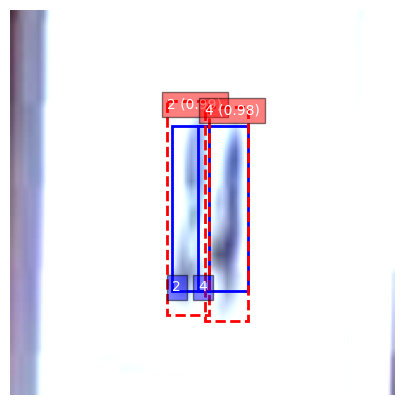

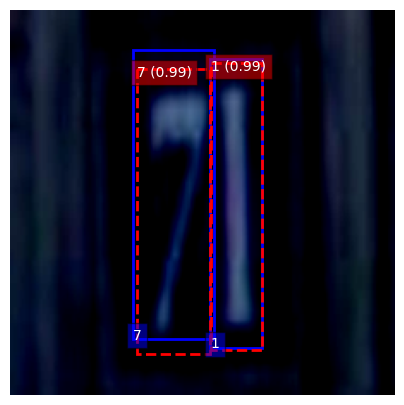

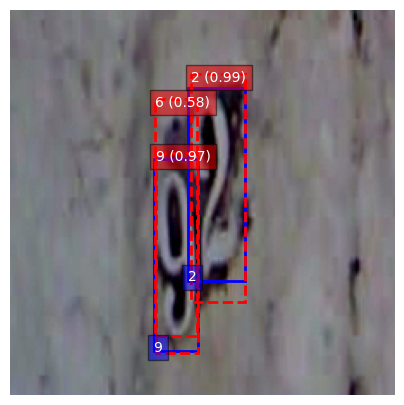

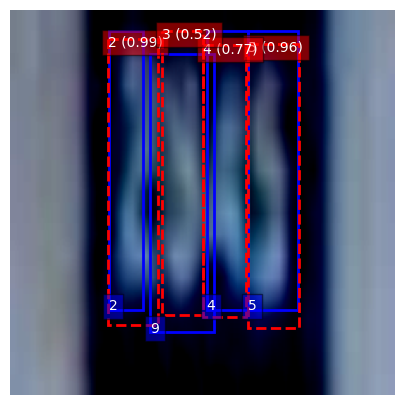

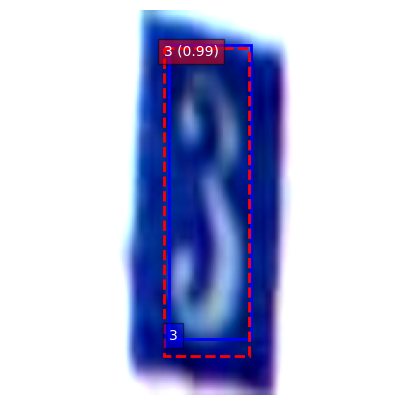

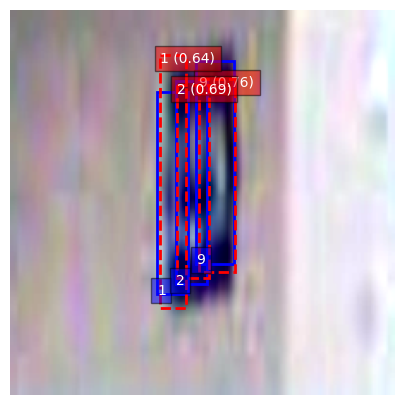

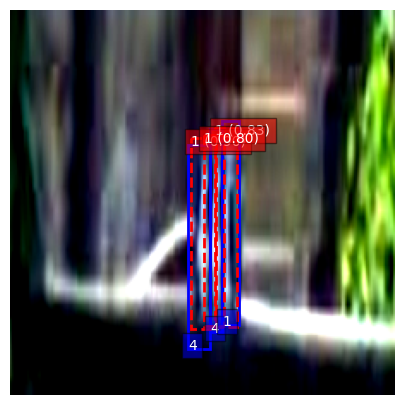

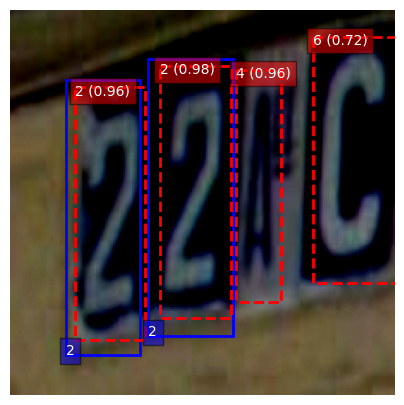

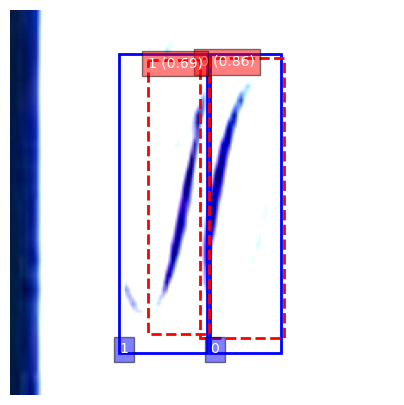

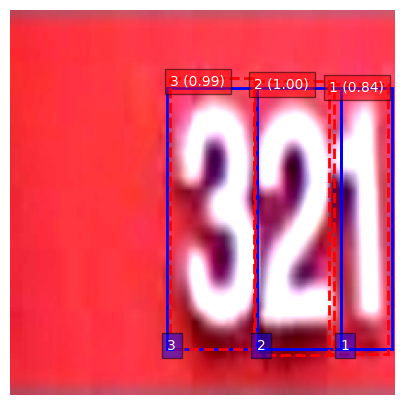

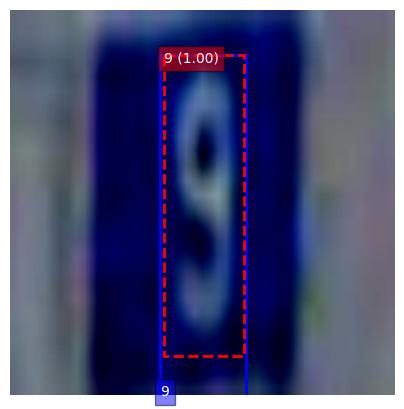

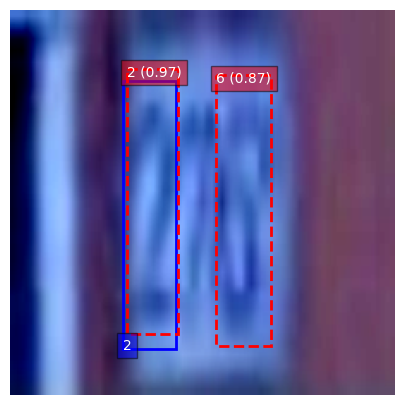

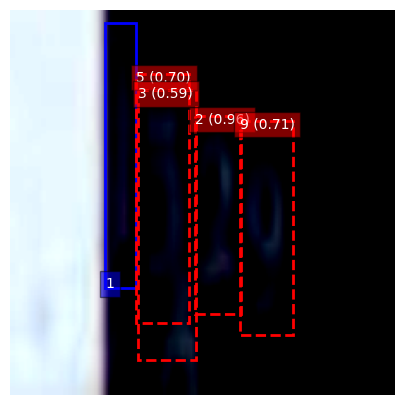

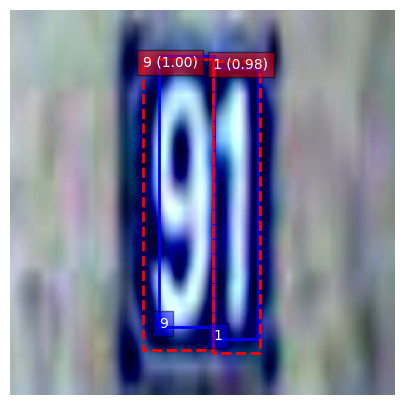

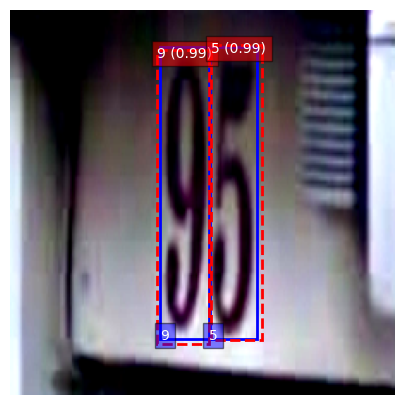

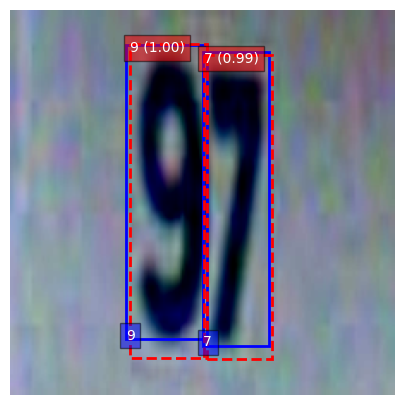

In [59]:
import random
import torch
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_validation_image(image, target, prediction, score_threshold=0.5):

    image = F.normalize(image, mean=[-1, -1, -1], std=[2, 2, 2])  
    image_np = image.cpu().numpy().transpose((1, 2, 0))  
    image_np = np.clip(image_np, 0, 1) 

    plt.figure(figsize=(5, 5))
    plt.imshow(image_np)

    true_boxes = target['boxes'].cpu().numpy()
    pred_boxes = prediction['boxes'].cpu().numpy()
    pred_scores = prediction['scores'].cpu().numpy()
    pred_labels = prediction['labels'].cpu().numpy()

    # draw ground true bounding boxes (blue)
    for box, label in zip(true_boxes, target['labels'].cpu().numpy()):
        rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='blue', facecolor='none')
        plt.gca().add_patch(rect)
        
        label_text = f'{label}' if label != 10 else '0'
        plt.text(box[0], box[3] + 2, label_text, color='white', fontsize=10, ha='left', va='bottom', bbox=dict(facecolor='blue', alpha=0.5))
        
    # draw predicted boxes given by model (red)
    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
        # the model could output something with very low score so filter them out according to given 'score_threshold'
        if score > score_threshold:
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='red', facecolor='none', linestyle='--')
            plt.gca().add_patch(rect)
            
            label_text = f'{label.item()}' if label.item() != 10 else '0'  
            plt.text(box[0], box[1] - 2, f'{label_text} ({score:.2f})', color='white', fontsize=10, ha='left', va='top', bbox=dict(facecolor='red', alpha=0.5))

    plt.axis('off')
    plt.show()

def visualize_batch(model, data_loader, device, score_threshold=0.5):

    for i, (images, targets, image_names) in enumerate(data_loader):
        images = images.to(device)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            
        model.eval()
        with torch.no_grad():
            predictions = model(images)
            
        for j in range(len(images)):
            image = images[j]
            target = targets[j]
            prediction = predictions[j]
                
           
            image_display = F.normalize(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
            visualize_validation_image(image_display, target, prediction, score_threshold)
        break

num_classes = 11
model = get_model(num_classes)

weights_path = 'faster_rcnn_weights/model_epoch_3.pth'
model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))

model.eval()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

visualize_batch(model, val_loader, device, score_threshold=0.5)
